In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import emoji
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter

In [2]:
#Regex für '18.04.18, 20:38 -'
def startsWithDateTime(s):
  phoneNumRegex = r'^([0-2][0-9]|(3)[0-1])(\.)(((0)[0-9])|((1)[0-2]))(\.)(\d{2}|\d{4}), ([0-9][0-9]):([0-9][0-9]) -'  #Datum und Uhrzeit
  result = re.match(phoneNumRegex, s)
  if result:
    return True
  return False

In [3]:
#Regex für 'Meo:'
def startsWithAuthor(s):
  patterns = [
      '([\w]+):',                        # Vorname
      '([\w]+[\s]+[\w]+):',              # Vorname + Nachname
      '(.[\w]+[\s]+[\w]+):',             # .Vorname + Nachname
      '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # Vorname + Zweiter Vorname + Nachname
      '([+]\d{2} \d{3} \d{8})'           # Handy Nummer (Europa)
  ]
  pattern = '^' + '|'.join(patterns)
  result = re.match(pattern, s)
  if result:
    return True
  return False

In [4]:
#Nachricht aufteilen
def getDataPoint(line):
    # line = 18.04.18, 20:38 - Meo: LOOOOL
    
    splitLine = line.split(' - ') # splitLine = ['18.04.18, 20:38', 'Meo: LOOOOL']
    
    dateTime = splitLine[0] # dateTime = '18.04.18, 20:38'
    
    date, time = dateTime.split(', ') # date = '18.04.18'; time = '20:38'
    
    message = ' '.join(splitLine[1:]) # message = 'Meo: LOOOOL'
    
    if startsWithAuthor(message): # True (Funktion startsWithAuthor())
        splitMessage = message.split(': ') # splitMessage = ['Meo', 'LOOOOL']
        author = splitMessage[0] # author = 'Meo'
        message = ' '.join(splitMessage[1:]) # message = 'LOOOOL'
    else:
        author = None
    return date, time, author, message

In [5]:

parsedData = [] # Liste für Pandas
conversationPath = './WhatsApp Chat mit Lactovegetarier lvl 3🍫🐰.txt' 
with open(conversationPath, encoding="utf-8") as fp:
    fp.readline() # Erste Zeile überspringen
        
    messageBuffer = [] # Buffer für mehrzeilige Nachrichten
    date, time, author = None, None, None # Variablen der aktuellen Nachricht
    
    while True:
        line = fp.readline() 
        if not line: # Stop am Ende der Datei
            break
        line = line.strip()
        if startsWithDateTime(line): # Wenn Zeile mit DateTimePattern beginnt ist das eine neue Zeile (Funktion startsWithDateTime())
            if len(messageBuffer) > 0: # Check ob der buffer etwas enthält
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) # parsedData mit dem buffer füllen
            messageBuffer.clear() # buffer leeren
            date, time, author, message = getDataPoint(line) # Nachricht aufteilen (Funktion getDataPoint())
            messageBuffer.append(message) # Nachricht zum buffer hinzufügen
        else:
            messageBuffer.append(line) # Wenn Zeile nicht mit Datum anfängt ist es eine mehrzeile Nachricht, dann zum buffer hinzufügen

df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message'])

In [6]:
df_clean = df.replace(['.kiki königsschluckspecht', '.56er Jengelz', '+49 176 97698782'],['Alex', 'Kevib', 'Flo'])

In [7]:
df_clean.Author.unique()

array(['Meo', 'Tommy', 'Alex', 'Patrick', 'Dima', 'Kevib', 'Flo', 'Niggo',
       None], dtype=object)

In [8]:
df_clean.describe()

,Date,Time,Author,Message
count,41552,41552,41499,41552
unique,619,1348,8,29113
top,24.05.18,12:24,Alex,<Medien ausgeschlossen>
freq,448,82,10724,3837


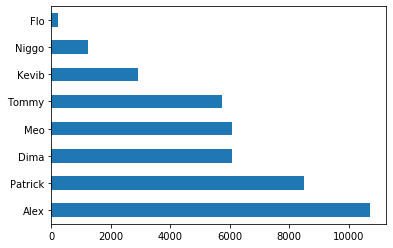

In [9]:
author_value_counts = df_clean['Author'].value_counts() # Anzahl Nachrichten pro Author
author_value_counts.plot.barh() # Plot a bar chart mit Pandas

        Date   Time   Author                  Message
3   18.04.18  20:55    Tommy  <Medien ausgeschlossen>
7   19.04.18  05:39    Tommy  <Medien ausgeschlossen>
11  19.04.18  07:39  Patrick  <Medien ausgeschlossen>
15  19.04.18  08:46     Dima  <Medien ausgeschlossen>
16  19.04.18  09:01     Alex  <Medien ausgeschlossen>


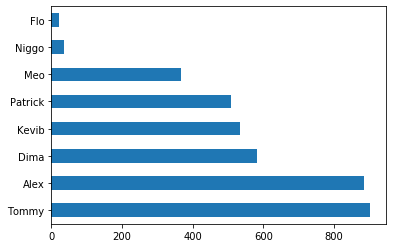

In [10]:
#Am meisten verwesendete Medien pro Author
media_messages_df = df_clean[df_clean['Message'] == '<Medien ausgeschlossen>']
print(media_messages_df.head())

author_media_messages_value_counts = media_messages_df['Author'].value_counts()
top_10_author_media_messages_value_counts = author_media_messages_value_counts.head(10)
top_10_author_media_messages_value_counts.plot.barh()

In [11]:
null_authors_df = df[df['Author'].isnull()]
null_authors_df.head()

,Date,Time,Author,Message
415,23.04.18,22:25,None,‎Dima hat das Gruppenbild geändert.
1586,15.05.18,11:48,None,‎.56er Jengelz hat das Gruppenbild geändert.
2194,23.05.18,18:26,None,‎Tommy hat das Gruppenbild geändert.
3476,29.05.18,21:35,None,‎.56er Jengelz hat das Gruppenbild geändert.
3522,30.05.18,10:59,None,‎Tommy hat das Gruppenbild geändert.


In [12]:
messages_df = df_clean.drop(null_authors_df.index) # Alle Nachrichten mit NULL als Author löschen
messages_df = messages_df.drop(media_messages_df.index) # Alle <Medien ausgeschlossen> Nachrichten löschen
messages_df.head()

,Date,Time,Author,Message
0,18.04.18,20:38,Meo,x)
1,18.04.18,20:40,Meo,Oder man springt aus 200 Metern ins Wasser.. V...
2,18.04.18,20:40,Tommy,Vomg dicke her
4,18.04.18,20:55,Tommy,#dickefinger
5,18.04.18,20:56,Tommy,Russischer Pop empfohlen weil ich Dr. Dre gehö...


In [13]:
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s)) #Letter Count erstellen
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' '))) #Word Count erstellen
messages_df.head()

,Date,Time,Author,Message,Letter_Count,Word_Count
0,18.04.18,20:38,Meo,x),2,1
1,18.04.18,20:40,Meo,Oder man springt aus 200 Metern ins Wasser.. V...,71,13
2,18.04.18,20:40,Tommy,Vomg dicke her,14,3
4,18.04.18,20:55,Tommy,#dickefinger,12,1
5,18.04.18,20:56,Tommy,Russischer Pop empfohlen weil ich Dr. Dre gehö...,53,9


In [14]:
#Anzahl versendeter Buchstaben und Wörter
messages_df['Letter_Count'].sum(), messages_df['Word_Count'].sum()

(1062481, 190337)

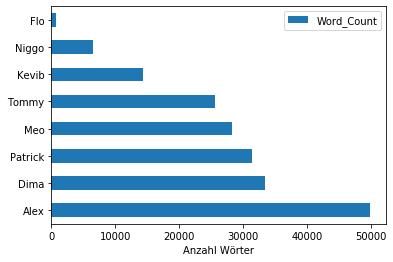

In [35]:
#Anzahl versendeter Wörter pro Author
total_word_count_grouped_by_author = messages_df[['Author', 'Word_Count']].groupby('Author').sum()
sorted_total_word_count_grouped_by_author = total_word_count_grouped_by_author.sort_values('Word_Count', ascending=False)
sorted_total_word_count_grouped_by_author.plot.barh()
plt.xlabel('Anzahl Wörter')
plt.ylabel('')
plt.savefig('Anzahl_Wörter.png')

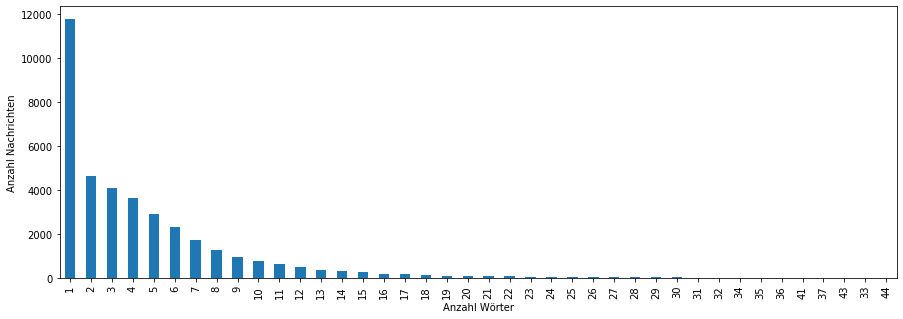

In [36]:
#Häufigste Anzahl von Wörtern in einer Nachricht
plt.figure(figsize=(15, 5)) # To ensure that the bar plot fits in the output cell of a Jupyter notebook
word_count_value_counts = messages_df['Word_Count'].value_counts()
top_40_word_count_value_counts = word_count_value_counts.head(40)
top_40_word_count_value_counts.plot.bar()
plt.xlabel('Anzahl Wörter')
plt.ylabel('Anzahl Nachrichten')
plt.savefig('Häufigste_Anzahl_Wörter_in_Nachricht.png')

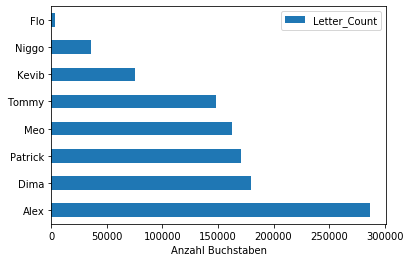

In [37]:
#Anzahl aller versendeten Buchstaben pro Author
total_letter_count_grouped_by_author = messages_df[['Author', 'Letter_Count']].groupby('Author').sum()
sorted_total_letter_count_grouped_by_author = total_letter_count_grouped_by_author.sort_values('Letter_Count', ascending=False)
sorted_total_letter_count_grouped_by_author.plot.barh()
plt.xlabel('Anzahl Buchstaben')
plt.ylabel('')
plt.savefig('Anzahl_Buchstaben.png')

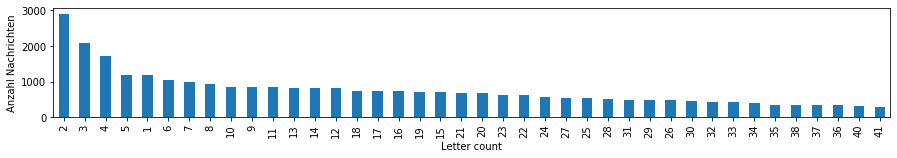

In [38]:
#Häufigste Anzahl von Buchtaben in einer Nachricht
plt.figure(figsize=(15, 2))
letter_count_value_counts = messages_df['Letter_Count'].value_counts()
top_40_letter_count_value_counts = letter_count_value_counts.head(40)
top_40_letter_count_value_counts.plot.bar()
plt.xlabel('Letter count')
plt.ylabel('Anzahl Nachrichten')
plt.savefig('Häufigste_Anzahl_Buchstaben_in_Nachricht.png')

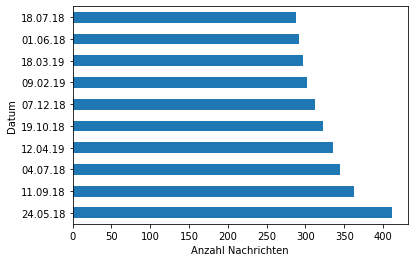

In [39]:
#Top 10 der Tage an denen am meisten Nachrichten versendet wurden
messages_df['Date'].value_counts().head(10).plot.barh() # Top 10 Dates on which the most number of messages were sent
plt.xlabel('Anzahl Nachrichten')
plt.ylabel('Datum')
plt.savefig('Tage_mit_den_meisten_nachrichten.png')

Text(0, 0.5, 'Time')

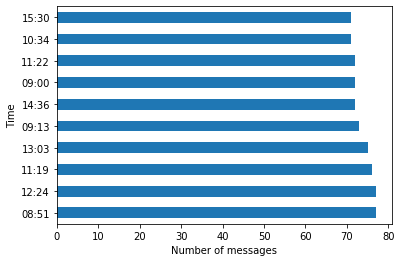

In [20]:
#Zeit zu der die meisten Nachrichten versendet werden
messages_df['Time'].value_counts().head(10).plot.barh() # Top 10 Times of the day at which the most number of messages were sent
plt.xlabel('Number of messages')
plt.ylabel('Time')

Text(0, 0.5, 'Hour of Day')

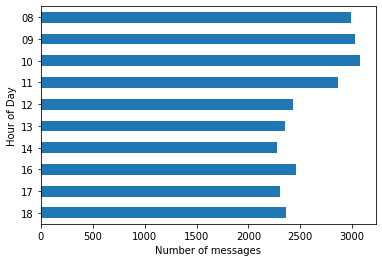

In [21]:
#Zu welcher Stunde des Tages werden die meisten nachrichten versendet
messages_df['Hour'] = messages_df['Time'].apply(lambda x : x.split(':')[0])
messages_df['Hour'].value_counts().head(10).sort_index(ascending=False).plot.barh() # Top 10 Hours of the day during which the most number of messages were sent
plt.xlabel('Number of messages')
plt.ylabel('Hour of Day')

In [22]:
#Alle verwendeten Emojis
def extract_emojis(str):
    return ''.join(c for c in str if c in emoji.UNICODE_EMOJI)

emojis = extract_emojis(messages_df['Message'])

emojis

'🤨😊🙏😜😳😅😂🤤😂😊😌🤤🤨🤤😊🤗😊😁😂😅🙊😂😂🤤😂😂😂🙃😘😋🤨👍😂🤔🙊😇🤤😌👌🤤☺🤤🙊😌👌🤨👌🤤😬😞😊😏😂😳😘😏😏🙃😂😏😌🙊😏🙂😏🤮😏😎😏😑🤓😆😍😁👌😅😑🤪☺🤗😝🙁😘🤨😯😐🤓😏👍🤤😂😉🤭❤🤨😘🙈👍🏻🙈🐒🐞🙈🙈🤤😴👌🦖😜😂😅😅😅😅💡😱😂😉😔🌝🤭❤❤🍕🙄😂😉😂😉😏😂😂🙈😂🤤🤭😂😂🤔🤭🤭🙊❤🙈💔😏😢🤤🙃😘👌😏🤔👻💔🖕🏻😩😊🙃😂🙈✌🤭🤭🦂😊🙂😜😂😂😠😵🙄👌😏😂😅😳😔😯😏😂😂🤤😏☹🤨🤤😶🤭🤨😑😋☹😊😊🦕☺🐧🐼💩😅🦍❤😏👐🏿❤😊😏🐧🤺😷😅😁❤😕💕❤❤😏😕🐔🧐🤮🤭✌🧐📺☺😘🧐😞😯☺❤🤭😔🤭😮😏🧐❤❤😏😂🌌🤮🙄😆🙃🧐😂😏🐱😲☺🙃😏😂😂😂🧐🤔🧐🖕🏼😨😍😏😂😘😮😂🦃🐗🤺😂🤔🤔🙀🤔🤭😲🥢🤤🤺🧐😕😘😂😛😇🙃🤫😂😘🐝🧐😛😏😪😉☺😂😲😔🤭🤺😂😴💩🤔😯😊🙃🌀😗🤕🤮😂🤨🆘🦠😘🐦😂🤤🤤🤭👩🏼👌👍🤭😔🤨🤨🙄🤤🙁😒🙁💗😳🙁👌🏻👌🖕🏼😂🤪🤓🤭🙂☄🌪🙂😟🙈😂🥳🥳🤤💕😁😋🤭😝😳😭🖕🏼😏✊✊🙈😁😂😍🤭👀👍🤓😂😂🙁😇🤨😅😊😏🤗😍🙁😂😒💗👌🏻👍🏻🤭☺👌😘🙏😍🤭😏😳🥶🥶😒😏😂☺😂🙊😏🙊😂😍🤔😂😏😘🥴😢❤😍😋🥰👅🙁🙁🤦\u200d♀️🐷🤤😍😕😂👎🧐🥰😳😨☹🥺🥺🙈😍🤭🤔😍😊😨🧠😂😳🤭💕😳😲😂🥴🥳😂💩😚🙊☃☹😂😂🥴😳🥰🏐😟😂😂🙊🐷😒😳🤓🙈😂🤭😂😳🙄😂🤭🤩😧😌👌😂😂🙄🥺🤔😂🥴😂😘🤤😂😂🤭😄😁😂😂😱😂😘😂😊😇💋😏🙄😶😂🙁😧😂😳😍🤭😂😂😯😏😍😂🤓🤓😂😂😂😅🙊🤔😎🤓😊👋🍺🍻🤤👌🤪🤓🤓🙏😬😳👀😳👌😂😂😍😂❤❤🤓❤😝😳🙈😂😘😂❤🙃😭😮🥴❤😘😊😂😂💋🤤😁🥴😳😂😍🥴✌😏😂🤫🙊😏😍😏🤓🤓😱😂😅😳❤❤🙊😳😏🙂🤓☹😒❤😳🥰😂🥴😂😳😴😂😳❤🤨🙄🙄😍😅😱🤗🤓😂🥳🙃😘😇😢🤔😳👌😈👹👌🏻😥😳😳😂😘😏😳🤤❤❤💋😊😏😂😍😂🤤🤓😂😀🙄😚😳😏😒🙄😂😏😜😳😐😊😊😟😔😳😍❤🥰😊😊😳🤠😔😱😂🙄😍😏😭😂🗿🙃😍☹😘☹🤓😱😊🤓🙂😂😊🥵😂😥☹😅😅🤯🙂💕😂😊😘😝😋😊😱😋😱😂👍👍👍😍☺😆👌🧂👌😂😌🥰🤤😘😱😏😂🤔😂😂🤪😋😓❤😂👀👀🧐😎😘❤😊👀😘🥰😂🤓🥺😳😥😍😎🥰🤙🤙🐥😄👀😂🤔🙈🥰🥰😱😏😊💕🙈😏😳😘❤🥰🙄😊🤓😏😏😳👀👌🏻👌👍❤❤🤤🤓😳💕😏☹😊😂🤤❤💩😂😂😂😂👌🤔🙄👌🏻😘😋😊😘🧕🤤🤤👌🥵🥶🥵😥🙈🙏😅😂😂😁👌🏻😂🙄😏🥴🤤😂😂🤤🤤😏😏🥰😂🤤🙏😁😏🙈😏🥰🤔😇🥰🤤😂😳🤭😏🤤😂😂😎😍👌😘😊😂😭🙄😂😂😂😊🤓😳😊😳😏😳😂🙄😎🤖🥺😊🙄😏😊😎😋🙄🙄😍😂😂☹🙄❤😎🙈😂🙄😊🐼😂😂😏😬😮😂😇😂😏😊😂🧻🙄😒🙈🐼😇😳😳❤😂😏🤤😁😫💤😳🤗😂😇😬😊🧐😳😑😑😅☺😋😚🤤🐼🙃😝😏🙄😘🤤😘🥰🤓😏🙄😏😂😊🤪😂😂😳😏😂😳🐼😏

In [23]:
#Alle verwendeten Emojis Dict
emoji_dict = {i:emojis.count(i) for i in emojis}
#emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1])
#emoji_dict = OrderedDict(sorted(emoji_dict.items(), key=lambda x: x[1]))

#for k,v in emoji_dict:
    #print (k, v)
emoji_dict

{'🤨': 15,
 '😊': 39,
 '🙏': 7,
 '😜': 6,
 '😳': 45,
 '😅': 18,
 '😂': 155,
 '🤤': 44,
 '😌': 6,
 '🤗': 5,
 '😁': 10,
 '🙊': 12,
 '🙃': 14,
 '😘': 29,
 '😋': 10,
 '👍': 10,
 '🤔': 17,
 '😇': 12,
 '👌': 28,
 '☺': 11,
 '😬': 4,
 '😞': 2,
 '😏': 64,
 '🙂': 7,
 '🤮': 4,
 '😎': 8,
 '😑': 5,
 '🤓': 24,
 '😆': 3,
 '😍': 27,
 '🤪': 5,
 '😝': 5,
 '🙁': 9,
 '😯': 5,
 '😐': 2,
 '😉': 5,
 '🤭': 27,
 '❤': 34,
 '🙈': 19,
 '🏻': 9,
 '🐒': 1,
 '🐞': 1,
 '😴': 3,
 '🦖': 1,
 '💡': 1,
 '😱': 10,
 '😔': 7,
 '🌝': 1,
 '🍕': 1,
 '🙄': 26,
 '💔': 2,
 '😢': 3,
 '👻': 1,
 '🖕': 4,
 '😩': 1,
 '✌': 3,
 '🦂': 1,
 '😠': 1,
 '😵': 1,
 '☹': 10,
 '😶': 2,
 '🦕': 1,
 '🐧': 2,
 '🐼': 6,
 '💩': 4,
 '🦍': 1,
 '👐': 1,
 '🏿': 1,
 '🤺': 4,
 '😷': 1,
 '😕': 4,
 '💕': 6,
 '🐔': 1,
 '🧐': 12,
 '📺': 1,
 '😮': 4,
 '🌌': 1,
 '🐱': 1,
 '😲': 4,
 '🏼': 4,
 '😨': 3,
 '🦃': 1,
 '🐗': 1,
 '🙀': 1,
 '🥢': 1,
 '😛': 3,
 '🤫': 2,
 '🐝': 1,
 '😪': 1,
 '🌀': 1,
 '😗': 1,
 '🤕': 1,
 '🆘': 1,
 '🦠': 1,
 '🐦': 1,
 '👩': 1,
 '😒': 7,
 '💗': 2,
 '☄': 1,
 '🌪': 1,
 '😟': 3,
 '🥳': 5,
 '😭': 4,
 '✊': 2,
 '👀': 11,
 '🥶': 3,
 '🥴': 11,
 '🥰': 20

In [24]:
#20 Am häufigsten verwendeten Emojis
emoji_top20 = dict(Counter(emoji_dict).most_common(20))
emoji_top20

{'😂': 155,
 '😏': 64,
 '😳': 45,
 '🤤': 44,
 '😊': 39,
 '❤': 34,
 '😘': 29,
 '👌': 28,
 '😍': 27,
 '🤭': 27,
 '🙄': 26,
 '🤓': 24,
 '🥰': 20,
 '🙈': 19,
 '😅': 18,
 '🤔': 17,
 '🤨': 15,
 '🙃': 14,
 '🙊': 12,
 '😇': 12}

In [25]:
#Plot für die 20 häufigsten verwendeten Emojis
#plt.bar(*zip(*emoji_top20.items()))
#plt.xlim(0, 20)
#plt.show()

In [26]:
#Alle Nachrichten als ein langer Text
message_text = ' '.join(messages_df['Message'].tolist())
message_text


'x) Oder man springt aus 200 Metern ins Wasser.. Verliert man auch keine HP Vomg dicke her #dickefinger Russischer Pop empfohlen weil ich Dr. Dre gehört habe Ersma rückwärts fahren im ice Eher Hennef oder weiter im Anus. ☺ 🤨 Da hat der ICE aber nicht gehalten Kleiner kack Bahnhof Alde Bin raus Ohrlappen dick 😂 Wieder bester mann Alle selfies am durchgucken, bei jedem bild so 🆗🆒 Und dann kommt offis bild, und dann so: 🙊 😊 Handy am testen bahaha Dein 5310? 5310? Nokia 5310 du Fotze Huawei p smart Düfte Lol Gg Handy Dufotze Wo haste gekauft? Bei wir kaufen dein Auto.de NENN MIR MAL EINE VERFICKTE DOMAIN MIT LEERZEICHEN AMENA... UNMÖGLICH SOWAS Lul Sorry Herr Profi Https//:www.Wirfickenmeosanus.com/dummehure *https, *wir, *hure/  Dann wäre alles richtig. www.haltdeinmaul.de Ok Professor Doktor Digga Setz den Fokus auf die Dozentin und nicht deinen Tisch. 😏 Alles mache ich falsch heute 😕😕 Liegt am Wetter ☺ Darfst auch mal mit meinem Kuga fahren Ich will auch mit „deinen“ kuga fahren ☹ Lul n

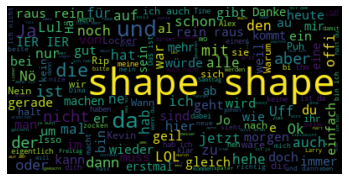

In [27]:
#Wordcloud
# Start with one review:
text = message_text

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()